[Quantile regression](https://www.youtube.com/playlist?list=PLG8higEnlmAEcIvtr1Miql-f2nxsqpoEH)

## <center> Implementation</center>

Optimization terminated successfully.
         Current function value: 692.242262
         Iterations: 356
         Function evaluations: 650
Optimization terminated successfully.
         Current function value: 1087.014259
         Iterations: 325
         Function evaluations: 580
Optimization terminated successfully.
         Current function value: 1340.698746
         Iterations: 312
         Function evaluations: 545
Optimization terminated successfully.
         Current function value: 1528.279091
         Iterations: 389
         Function evaluations: 731
Optimization terminated successfully.
         Current function value: 1333.419669
         Iterations: 133
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 1073.080518
         Iterations: 343
         Function evaluations: 606
Optimization terminated successfully.
         Current function value: 671.155741
         Iterations: 169
         Function evaluations: 305


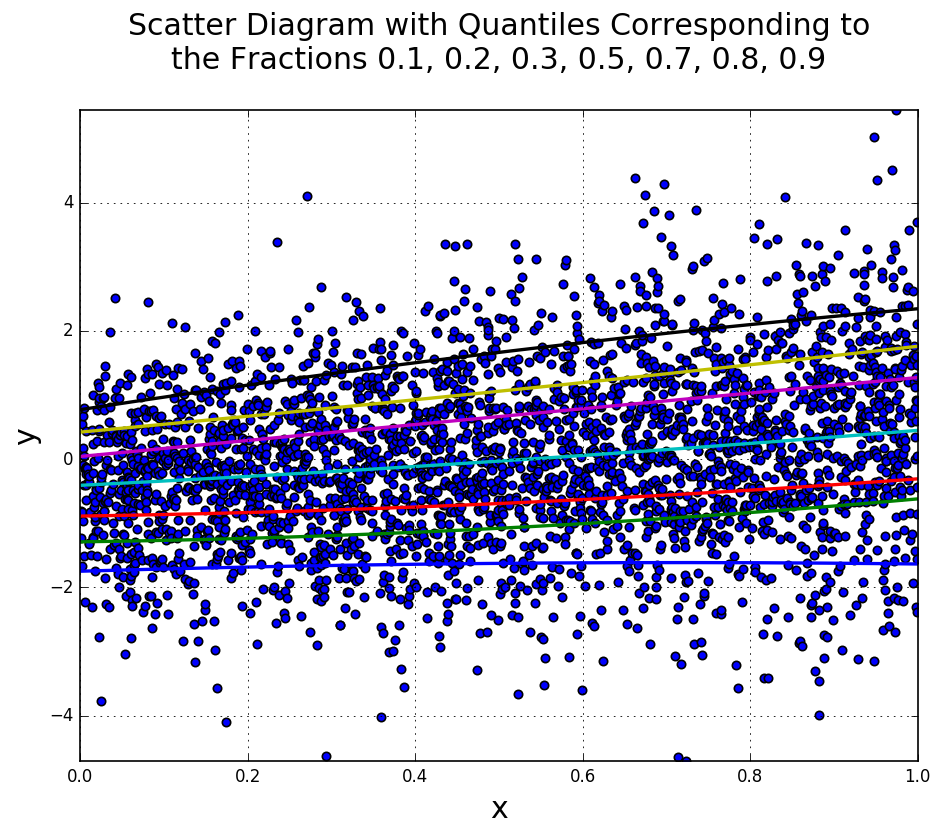

In [39]:
"""
quantile_regression_demo.py


OVERVIEW

Most of us are familiar with the charts that pediatricians use that show
percentiles of weight and height as a function of age; generating such a chart
from a small sample of data requires quantile regression or similar methods.
(When working with a large enough sample of data, one can bin the data, i.e.,
divide the x-axis into intervals and calculate percentiles independently for
each interval.  But, this approach uses the data inefficiently and is unworkable
when sample sizes are small).

Quantiles and percentiles are the same except for a factor of 100, e.g., the
30th percentile is the 0.3 quantile.

This Python script demonstrates that one can perform quantile regression using
only Python, NumPy, and SciPy.  The only other dependency is on matplotlib,
which is used to plot the data and the quantile estimates.


In detail, the script does the following:


(1) Model parameters are assigned.  (Currently, these are hardwired into the
code).


(2) The program generates an artificial bivariate sample of data (x, y) as
follows:

- x is generated by drawing from a distribution that is uniform on [x_min,
x_max], where x_min and x_max are currently 0 and 1, respectively.

- y is then generated according to a normal distribution having mean -0.5 + x
and standard deviation 1.0 + 0.5 * x.

(All of this can be changed, e.g., one could choose to make the mean of y
quadratic in x).


(3) The code defines an objective function based on the tilted absolute value
function (see references for motivation).


(4) The SciPy optimization package is then used to optimize (minimize) the
objective function.


(5) Using the matplotlib module, the code plots a scatter diagram of the data
with an overlay of percentile lines.


NOTES

My initial approach to this problem was to use the rpy2 interface to the R
statistical environment to invoke the R quantreg package, but the rpy2 module is
severely buggy, and I was unable to make this work.


REFERENCES

1. Journal article, 'Quantile Regression',
http://www.econ.uiuc.edu/~roger/research/rq/QRJEP.pdf

2. Powerpoint slides, 'Robust Statistics and Quantile Regression',
http://www.savbb.sk/~grendar/pdf/robust_quantreg.pdf

3. For an introduction to the Rpy2 interface between Python and R:

http://rpy.sourceforge.net/rpy2/doc-2.1/html/introduction.html

4. Defining R formulas and the associated data is tricky.  For discussion and
examples, see the following:

http://rpy.sourceforge.net/rpy2/doc-2.3/html/robjects_formulae.html


AUTHOR

Dr. Phillip M. Feldman
"""

# Section 1: Import from modules.

from matplotlib import pyplot
import numpy, pdb
from numpy import array, pi
from numpy.polynomial.polynomial import polyval
from scipy.optimize import fmin


# Section 2: Define tilted absolute value function.

def tilted_abs(rho, x):
   """
   OVERVIEW

   The tilted absolute value function is used in quantile regression.


   INPUTS

   rho: This parameter is a probability, and thus takes values between 0 and 1.

   x: This parameter represents a value of the independent variable, and in
   general takes any real value (float) or NumPy array of floats.
   """

   return x * (rho - (x < 0))


# Section 3: Get user input parameters.  Currently, these are hardwired into the
# code.

# `N` is the number of random data points to be generated:
N= 3000

if   N <= 20:
   symbol_size= 100
elif N <= 200:
   symbol_size= 50
else:
   symbol_size= 25

x_min= 0.0; x_max= 1.0

# Define mean and standard deviation of y as functions of x using lambda
# notation:
y_mean= lambda x: -0.5 + x
y_std = lambda x: 1.0 + 0.5 * x

# Define number of polynomial coefficients.  (The degree of the model is one
# more than the number of coefficients).  Specify 2 for a linear model, 3 for a
# quadratic model, and so on.
N_coefficients= 3

fractions= [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

# Define seed (list of integers) for random number generator:
seed= [1, 2, 4]


# Section 4: Generate random datasets x and y.

# Create a random number stream:
RNG= numpy.random.RandomState(seed)

x= RNG.uniform(low=x_min, high=x_max, size=N)
y= y_mean(x) + y_std(x)*RNG.normal(loc=0.0, scale=1.0, size=N)

y_min= y.min(); y_max= y.max()

# Find indices that would sort x values into ascending order:
indices= numpy.argsort(x)

# Apply this sort order to both x and y:
x= x[indices]
y= y[indices]


# Section 5 (deactivated): Use the rpy2 interface to the R statistical
# environment to invoke the quantreg package to estimate quantiles of y as a
# function of x.

# # The R command-prompt syntax that one would use is as follows:

# #    library(quantreg)
# #    formula= ???
# #    fit1 <- rq(formula, tau=fractions)

# R.initr()
# R.library(quantreg)

# formula= R_objects.Formula('y ~ x')
# env= formula.environment
# env['x']= x
# env['y']= y

# fit1= R_objects.rq(formula, tau=fractions)


# Section 6: Estimate quantiles via direct optimization.

def model(x, beta):
   """
   This example defines the model as a polynomial, where the coefficients of the
   polynomial are passed via `beta`.
   """

   return polyval(x, beta)


def objective(beta, rho):
   """
   The objective function to be minimized is the sum of the tilted absolute
   values of the differences between the observations and the model.
   """
   return tilted_abs(rho, y - model(x, beta)).sum()


# Define starting point for optimization:
beta_0= numpy.zeros(N_coefficients)
if N_coefficients >= 2:
   beta_0[1]= 1.0

# `beta_hat[i]` will store the parameter estimates for the quantile
# corresponding to `fractions[i]`:
beta_hat= []

for i, fraction in enumerate(fractions):
   beta_hat.append( fmin(objective, x0=beta_0, args=(fraction,), xtol=1e-8,
     disp=True, maxiter=3000) )


# Section 7: Plot the data with overlays of estimated quantiles.

# Create figure window:
fig= pyplot.figure(figsize=[9,7], dpi=120, facecolor=[1,1,1])

# Plot (x,y) pairs on a scatter diagram.  The argument `s` specifies the symbol
# area in units of points squared.
p1= pyplot.scatter(x, y, s=symbol_size)
pyplot.xlim([x_min, x_max])
pyplot.ylim([y_min, y_max])
pyplot.title("Scatter Diagram with Quantiles Corresponding to\n"
  "the Fractions %s\n" % str(fractions)[1:-1], size=18)
pyplot.xlabel("x", size=18)
pyplot.ylabel("y", size=18)

# Enable 'hold' so that lines will be plotted as overlays on scatter diagram
# rather than in separate figure windows:
pyplot.hold(True)

# Draw a line for each quantile:
for i, fraction in enumerate(fractions):
   pyplot.plot(x, polyval(x, beta_hat[i]), linewidth=2)

pyplot.grid(True)

# Nothing is displayed until we invoke `show`:
pyplot.show()

# <center>Example 1</center>
This example shows how to use statsmodels'QuantReg class to replicate parts of the analysis published in 'Quantile Regression'.journal of Economec Perspectives,by Koenker,Roger adn Kevin F.Hallock.  

We are interested in the relationship between income and expenditures on food for a sample of working class Belgian households in 1857 (the Engel data).

In [20]:
%matplotlib inline
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

In [21]:
data=sm.datasets.engel.load_pandas().data

In [22]:
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


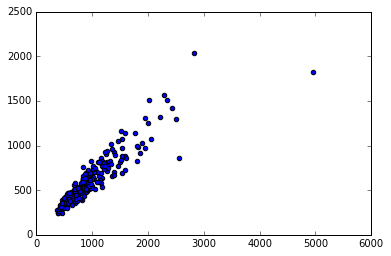

In [25]:
plt.scatter(data['income'],data['foodexp'])

## Least Absolute Deviation  
The LAD model is a special case of quantile regression where q=0.5  

In [7]:
mod=smf.quantreg('foodexp ~ income',data)
res=mod.fit(q=0.5)
print res.summary()

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Thu, 01 Jun 2017   No. Observations:                  235
Time:                        17:00:43   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000        52.649   110.315
income         0.5602      0.013     42.516      0.000         0.534     0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


## Visualizing the results  
We estimate the quantile regression model for many quantiles between 0.05 and 0.95,and compare best fit from each of these models to Ordinary Least Squares results.  

In [17]:
quantiles=np.arange(0.05,0.96,0.1)
def fit_model(q):
    res=mod.fit(q=q)
    return [q,res.params['Intercept'],res.params['income']]+ \
            res.conf_int().ix['income'].tolist()

models=[fit_model(x) for x in quantiles]
models=pd.DataFrame(models,columns=['q','a','b','lb','ub'])

ols=smf.ols('foodexp ~ income',data).fit()
ols_ci=ols.conf_int().ix['income'].tolist()
ols=dict(a=ols.params['Intercept'],
        b=ols.params['income'],
        lb=ols_ci[0],
        ub=ols_ci[1])

print models
print ols

c:\python27\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
c:\python27\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


      q           a         b        lb        ub
0  0.05  124.880100  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033435  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.47538852370579, 'b': 0.48517842367692332, 'lb': 0.45687381301842306, 'ub': 0.5134830343354235}


## First plot  
This plot comapres best fit lines for 10 quantile regression models to the least squares fit.As Koenker and Hallock (2001) point out ,we see that:  
1. Food expenditure increases with income  
2. The dispersion of food expenditure increases with income 
3. The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households)  

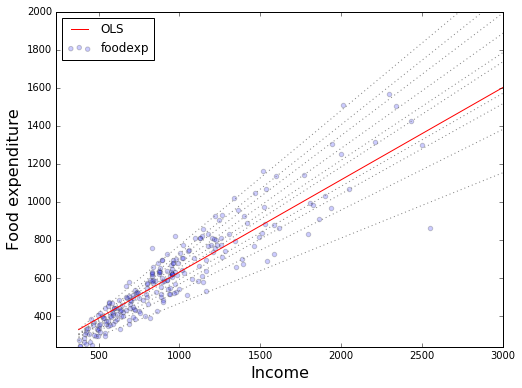

In [31]:
x=np.arange(data.income.min(),data.income.max(),50)
get_y=lambda a,b:a+b*x

fig,ax=plt.subplots(figsize=(8,6))

for i in range(models.shape[0]):
    y=get_y(models.a[i],models.b[i])
    ax.plot(x,y,linestyle='dotted',color='grey')

y=get_y(ols['a'],ols['b'])

ax.plot(x,y,color='red',label='OLS')
ax.scatter(data.income,data.foodexp,alpha=0.2)
ax.set_xlim((240,3000))
ax.set_ylim((240,2000))
legend=ax.legend(loc='best')
ax.set_xlabel('Income',fontsize=16)
ax.set_ylabel('Food expenditure',fontsize=16)

## Second plot  
The dotted black lines from 95% point-wise confidence band around 10 quantile regression estimate (solid black line).THe red lines represent OLS regression results along with their 95% donfidence interval.  

In most cases,the quantile regression point estimates lie outside the OLS confidence interval,which suggests that the effect of income on food expenditure may not be constant across the distribution. 

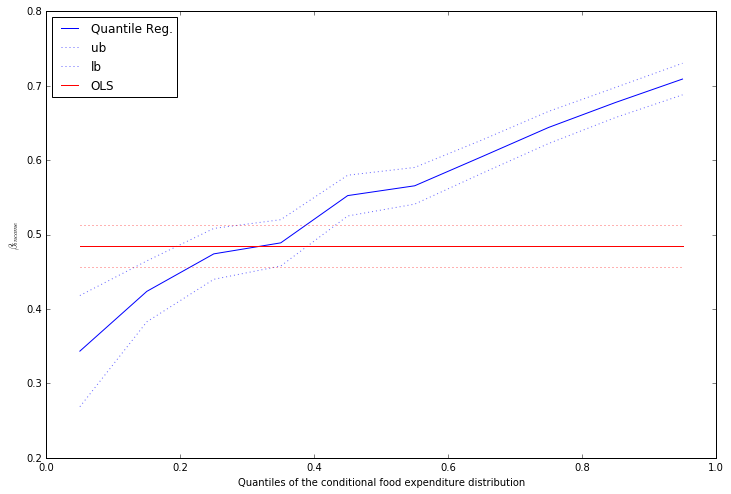

In [38]:
plt.figure(figsize=(12,8))
n=models.shape[0]
p1=plt.plot(models.q,models.b,color='blue',label='Quantile Reg.')
p2=plt.plot(models.q,models.ub,linestyle='dotted',color='blue',alpha=0.6)
p3=plt.plot(models.q,models.lb,linestyle='dotted',color='blue',alpha=0.6)
p4=plt.plot(models.q,[ols['b']]*n,color='red',label='OLS')
p5=plt.plot(models.q,[ols['lb']]*n,linestyle='dotted',color='red',alpha=0.6)
p6=plt.plot(models.q,[ols['ub']]*n,linestyle='dotted',color='red',alpha=0.6)

plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend(loc='best')
plt.show()

# <center> Example 2</center>  
[quantile regression for polynomial](https://stackoverflow.com/questions/35185046/using-statsmodels-to-plot-quantile-regression-for-2nd-order-polynomial)